In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f'/home/beans/bespoke')

from constants import *
from imports import *
from viz_utils import *
from train_utils import *
from traj_utils import *
from loaders import RunLoader
import threading

In [4]:
AUX_PROPS

['speed',
 'has_map',
 'has_route',
 'pitch',
 'yaw',
 'tire_angle',
 'pos_x',
 'pos_y',
 'heading',
 'has_stop',
 'stop_dist',
 'has_lead',
 'lead_dist',
 'lead_speed',
 'should_yield',
 'dagger_shift',
 'lane_width',
 'rd_is_lined',
 'interesting_note',
 'frame_to_model_duration',
 'loop_duration',
 'num_sats',
 'gps_qual',
 'unc_p',
 'shadow_strength',
 'directionality_mult',
 'maps_noise_mult',
 'roll_noise_mult',
 'te',
 'traj_max_angle_p',
 'ccs_p',
 'tire_angle_loss',
 'tire_angle_p',
 'left_turn',
 'right_turn',
 'curvature_at_ego',
 'tire_angle_lagged',
 'has_tire_angle',
 'tire_angle_dagger_corrected']

In [5]:
#run_id = "run_556a" # rr from hh to end pavement
#run_id = "run_556b" # po to end hh
#run_id = "run_555a" # rr out, sunny, glare
#run_id = "run_556c" # rr gravel
#556d, rr paved to gravel all the way home
#555b, rr sharp curve to PO

run_ids = ["run_555b", "run_556d"] + ["run_555a", "run_556a", "run_556b", "run_556c"]

In [6]:
# Temporary. Copying old rw into new format. Can delete when get new rw data.

for run_id in run_ids:
    run_path = f"/media/beans/ssd/bespoke_logging/{run_id}"

    for p in sorted(glob.glob(f"{run_path}/car_state/*")):
        cs = np.load(p)
        aux = get_aux_container(1,1)[0][0]
        aux["tire_angle"] = np.radians(cs[0]/STEER_RATIO)*-1
        aux["speed"] = cs[1]
        aux["pitch"] = 0
        aux["yaw"] = .5
        aux["pos_x"] = cs[13]
        aux["pos_y"] = cs[12]
        aux["has_map"] = 1
        aux["has_route"] = 1
        aux["tire_angle_lagged"] = aux["tire_angle"]
        aux["has_tire_angle"] = 1
        np.save(f"{run_path}/aux/{p.split('/')[-1]}", aux)


In [7]:
%%time
# Save rw data as Run object for faster loading. 
# Each time get a new rw run, or when update Run apparatus, rerun this

def do_run(run_id):
    run_path = f"{SSD_ROOT}/bespoke_logging/{run_id}"
    run = RunLoader(run_path, is_rw=True, redraw_maps=True, _gamma_correct_auto=True)
    print(run.img_chunk.shape, run.aux_chunk.shape, run.targets_chunk.shape)
    save_object(run, f"{SSD_ROOT}/runs/{run_id}.pkl")
    
threads = []
for run_id in run_ids:
    t = threading.Thread(target=do_run, args=(run_id,))
    t.start()
    threads.append(t)

for t in threads:
    t.join()

loaded imgs and aux
Redrawing maps using latest apparatus
0
1000
(1, 1898, 360, 1440, 4) (1, 1898, 39) (1, 1898, 120)
loaded imgs and aux
Redrawing maps using latest apparatus
0
1000
2000
3000
(1, 3298, 360, 1440, 4) (1, 3298, 39) (1, 3298, 120)
loaded imgs and aux
Redrawing maps using latest apparatus
0
loaded imgs and aux
Redrawing maps using latest apparatus
1000
0
2000
1000
3000
2000
3000
loaded imgs and aux
Redrawing maps using latest apparatus
0
1000
2000
3000
4000
(1, 3898, 360, 1440, 4) (1, 3898, 39) (1, 3898, 120)
(1, 3998, 360, 1440, 4) (1, 3998, 39) (1, 3998, 120)
loaded imgs and aux
Redrawing maps using latest apparatus
0
1000
2000
3000
4000
5000
(1, 4598, 360, 1440, 4) (1, 4598, 39) (1, 4598, 120)
(1, 5098, 360, 1440, 4) (1, 5098, 39) (1, 5098, 120)
CPU times: user 22min 45s, sys: 18min 17s, total: 41min 2s
Wall time: 6min 30s


In [2]:
wandb.init(id='1gdicwi9', project="carla", resume="allow")

wandb: Currently logged in as: rgilman33 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.13.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [3]:
from models import *
model_stem = "1.18_avg"
m = EffNet().to(device) 
m.model_stem = model_stem
m.load_state_dict(torch.load(f"{BESPOKE_ROOT}/models/m{model_stem}.torch"))

<All keys matched successfully>

In [4]:
%%time
from rollout import RwEvaluator
rw_evaluator = RwEvaluator(["run_555a", "run_556a", "run_556b", "run_556c"], m, wandb=wandb, save_rollouts=True)

CPU times: user 38.2 ms, sys: 13.2 s, total: 13.2 s
Wall time: 13.6 s


In [5]:
%%time
rw_evaluator.evaluate()

0
0
0
0


/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


loader is done
Rollout complete!
3200
3200
3200
loader is done
loader is done
Rollout complete!
loader is done
Rollout complete!
Rollout complete!
down w rollouts, reporting
run_556c
run_556b
run_556a
run_555a
CPU times: user 3min 45s, sys: 2min, total: 5min 45s
Wall time: 1min 56s


In [ ]:
%%time

# Evaluate a series of rw Run objects. Save the Rollouts for consolidation and viewing

from rollout import *
run_ids = ["run_555a", "run_556a", "run_556b", "run_556c"]
model_stem = "1.18_avg"

def do_rollout(run_id):
    run = load_object(f"{BESPOKE_ROOT}/tmp/runs/{run_id}.pkl")
    rollout = Rollout(run, model_stem)
    save_object(rollout, f"{BESPOKE_ROOT}/tmp/{run_id}_{model_stem}_rollout.pkl")
    print(f"Done w {run_id}")
    
threads = []
for run_id in run_ids:
    print(run_id)
    t = threading.Thread(target=do_rollout, args=(run_id))
    t.start()
    threads.append(t)

for t in threads:
    t.join()

### Seq from real

In [6]:
sorted(glob.glob("/media/beans/ssd/bespoke_logging/*"))[-10:]
#sorted(glob.glob("/home/beans/bespoke_logging/*"))

['/media/beans/ssd/bespoke_logging/run_555',
 '/media/beans/ssd/bespoke_logging/run_555a',
 '/media/beans/ssd/bespoke_logging/run_556',
 '/media/beans/ssd/bespoke_logging/run_556a',
 '/media/beans/ssd/bespoke_logging/run_556b',
 '/media/beans/ssd/bespoke_logging/run_556c',
 '/media/beans/ssd/bespoke_logging/run_557',
 '/media/beans/ssd/bespoke_logging/run_558',
 '/media/beans/ssd/bespoke_logging/run_559',
 '/media/beans/ssd/bespoke_logging/run_560']

In [9]:
#run_id = "run_555" # Out to ned, correct sized map, sun glary?
#run_id = "run_556" # back from ned, correct sized map

#run_id = "run_556a" # rr from hh to end pavement
#run_id = "run_556b" # po to end hh
#run_id = "run_555a" # rr out, sunny, glare
#run_id = "run_556c" # rr gravel


run_path = f"/media/beans/ssd/bespoke_logging/{run_id}"
#run_path = f"/home/beans/bespoke_logging/{run_id}"

model_stem = "1.15_e17" 

In [10]:
%%time
run = RunLoader(run_path, is_rw=True, redraw_maps=True, _gamma_correct_auto=False)

loaded imgs and aux
Redrawing maps using latest apparatus
0
1000
2000
3000
0
CPU times: user 3min 27s, sys: 41.5 s, total: 4min 9s
Wall time: 1min 27s


In [9]:
plt.imshow(run.maps[1000])

NameError: name 'run' is not defined

In [23]:
"""# seeing if cam is too slow, ie if we ever have repeated imgs

diffs = []
for i in range(len(img)-1):
    diff = (img[i] - img[i+1]).mean()
    diffs.append(diff)
    
# whether or not image is same as prev img, ie cam is slow. We just don't want to see zeros
plt.figure(figsize=(20,2))
plt.plot(diffs)"""

"# seeing if cam is too slow, ie if we ever have repeated imgs\n\ndiffs = []\nfor i in range(len(img)-1):\n    diff = (img[i] - img[i+1]).mean()\n    diffs.append(diff)\n    \n# whether or not image is same as prev img, ie cam is slow. We just don't want to see zeros\nplt.figure(figsize=(20,2))\nplt.plot(diffs)"

In [7]:
# img staleness
plt.figure(figsize=(20,2))
plt.plot(run.img_staleness)

AttributeError: 'RunLoader' object has no attribute 'img_staleness'

<Figure size 1440x144 with 0 Axes>

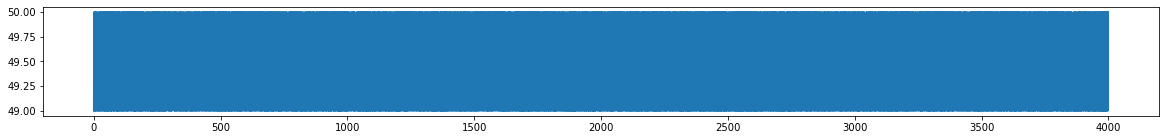

In [25]:
# loop duration
plt.figure(figsize=(20,2))
plt.plot(run.loop_duration)

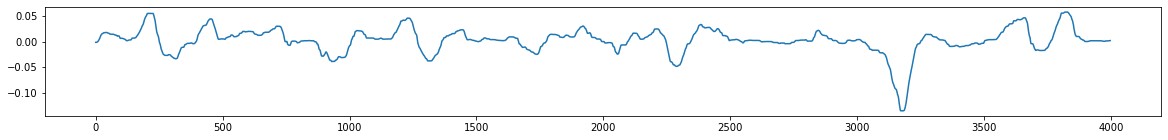

In [26]:
# tire angle
plt.figure(figsize=(20,2))
plt.plot(run.tire_angle)

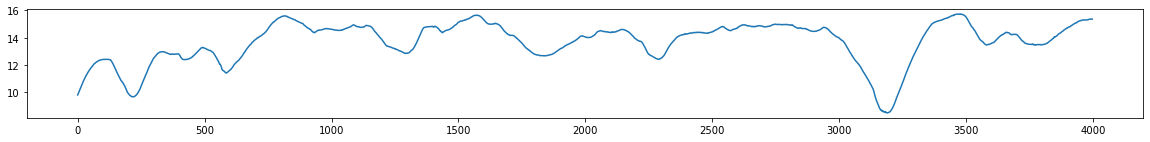

In [27]:
# speed
plt.figure(figsize=(20,2))
plt.plot(run.speed_mps)

In [28]:
"""import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(x=kph_to_mph(aux[:, 2]), y=np.sqrt(1/abs(steer_angle+.001)), width=600, height=600)
#fig.update_xaxes(range=[0, 50])
fig.update_yaxes(range=[0, 12])
fig.show()
"""
# The speed you can go is a linear fn of sqrt(1/curvature), steer_angle is a linear fn of curvature, given wheelbase

'import plotly.express as px\nimport plotly.graph_objects as go\n\nfig = px.scatter(x=kph_to_mph(aux[:, 2]), y=np.sqrt(1/abs(steer_angle+.001)), width=600, height=600)\n#fig.update_xaxes(range=[0, 50])\nfig.update_yaxes(range=[0, 12])\nfig.show()\n'

14686390.0

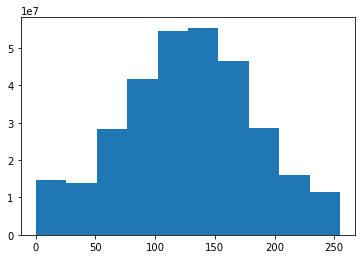

In [29]:
plt.hist(run.img_chunk[::20, :,:,:3].flatten())[0][0]

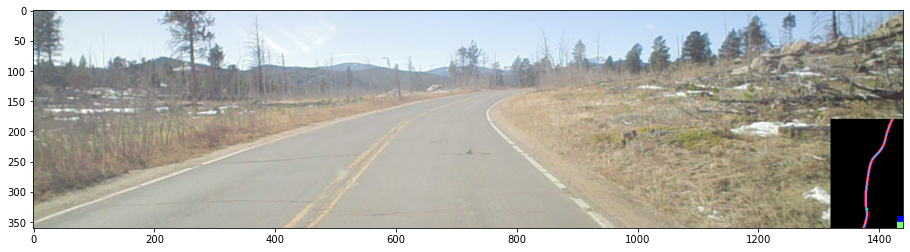

In [9]:
plt.figure(figsize=(20,4))
plt.imshow(run.img_chunk[0,1000, :,:,:3])

In [34]:
%%time


/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


1200
2400
3600
loader is done
Rollout complete!
CPU times: user 1min 5s, sys: 27.3 s, total: 1min 32s
Wall time: 1min 28s


In [35]:
run.reset()

0


In [36]:
calc_rollout_results(rollout)
flatten_rollout(rollout)
#write_vid(rollout.img[:,:,:,:3], 'vid3')

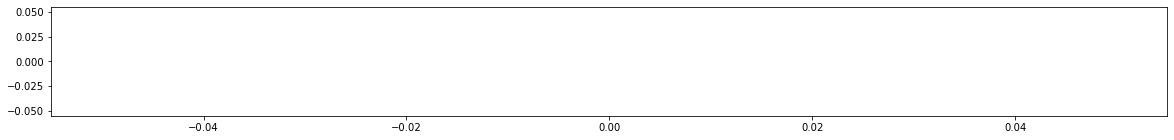

In [40]:
plt.figure(figsize=(20,2))
plt.plot(rollout.aux[:,"tire_angle"])
#plt.plot(rollout.additional_results[:,"tire_angle_p"])

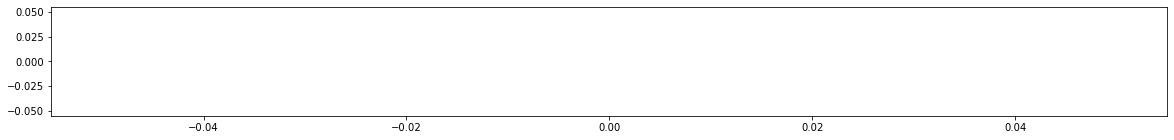

In [42]:
plt.figure(figsize=(20,2))
plt.plot(rollout.wps_p[:,0])

In [43]:
rollout.wps_p

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

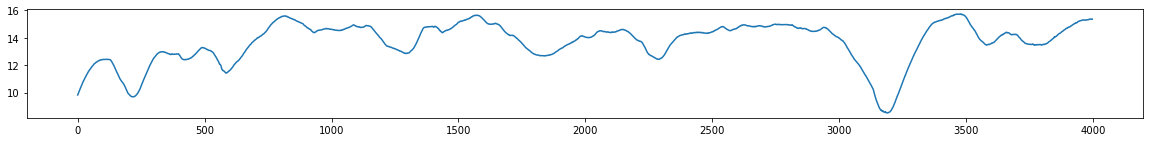

In [41]:
plt.figure(figsize=(20,2))
plt.plot(rollout.aux[:, "speed"])

In [24]:
rollout.additional_results[0]

NamedArray([0.00000000e+00, 1.96183827e-02, 3.00000000e+01,
            1.49591775e+00, 4.08224936e-03])

In [ ]:
ADD

In [33]:
%%time
# rollout.make_vid()

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 4.77 µs


In [34]:
%%time
rollout_f = f"{BESPOKE_ROOT}/tmp/{run.run_id}_{rollout.model_stem}_rollout.pkl"
save_object(rollout, rollout_f)

CPU times: user 151 ms, sys: 6.02 s, total: 6.18 s
Wall time: 7.89 s


In [ ]:
# TODO manually assemble these. Update OP for future

# CS_STEER_IX, CS_SPEED_IX, CS_STALENESS_IX, CS_LOOP_DURATION_IX, CS_INTERESTING_IX = 0, 1, 2, 3, 11
# CS_LAT_IX, CS_LON_IX = 12, 13

# car_state = np.stack([np.load(f) for f in sorted(glob.glob(f"{run_path}/car_state/*"))[s:e]])
# self.speed_mps = car_state[:,CS_SPEED_IX]
# self.tire_angle = np.radians(car_state[:,CS_STEER_IX] / (STEER_RATIO)) * -1
# self.wp_angles = None
# self.interesting_note = car_state[:, CS_INTERESTING_IX]
# self.img_staleness = car_state[:, CS_STALENESS_IX]
# self.loop_duration = car_state[:, CS_LOOP_DURATION_IX]
# self.lats = car_state[:, CS_LAT_IX]
# self.lons = car_state[:, CS_LON_IX]
# self.aux_chunk = np.zeros((len(car_state), N_AUX_TO_SAVE), dtype=np.float32)
# self.aux_chunk[:, AUX_PITCH_IX] = 0 #car_state[:,CS_PITCH_IX] TODO pipe these in from car_state itself
# self.aux_chunk[:, AUX_YAW_IX] = .5 #car_state[:,CS_YAW_IX]
# self.aux_chunk[:, AUX_SPEED_IX] = mps_to_kph(self.speed_mps) #TODO everything in mps


In [29]:
%%time
combine_vids(model_stem, "m_12.15_avg_gradcam", run_id)

Combining run_555_12.28_avg and run_555_m_12.15_avg_gradcam
run_555_12.28_avg shape (360, 1440, 3), run_555_m_12.15_avg_gradcam shape (720, 1490, 3)
combined!
CPU times: user 3min 37s, sys: 3.86 s, total: 3min 41s
Wall time: 3min 42s
